In [0]:
pwd


'/content'

In [0]:
#classifiers
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

#evaluation
from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv('../content/drive/My Drive/titanic_data/train.csv')
test = pd.read_csv('../content/drive/My Drive/titanic_data/test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
null_columns = train.columns[train.isnull().any()]
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa10158550>,
      dtype=object)

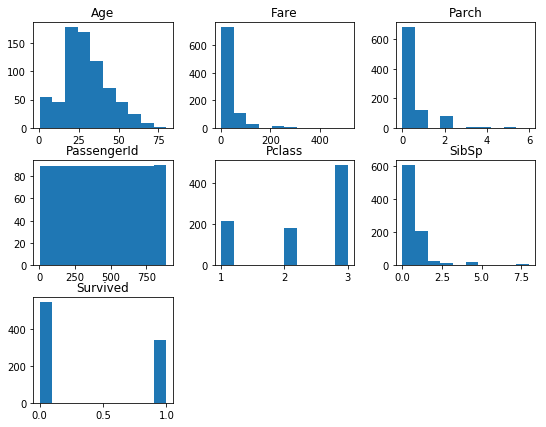

In [10]:
train.hist(bins = 10, figsize = (9,7), grid=False)

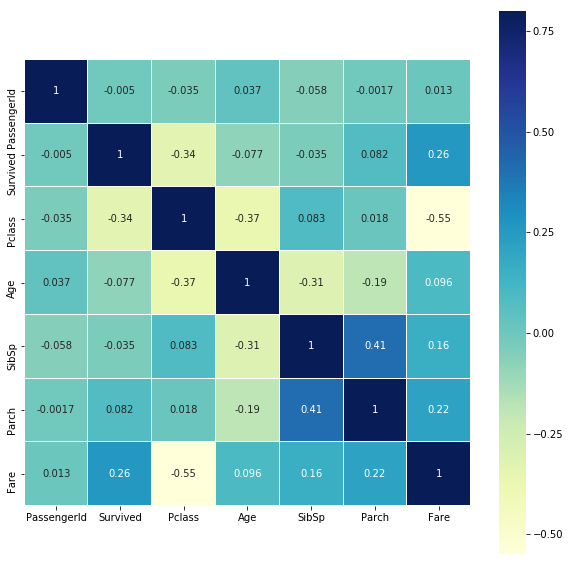

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = train.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax =.8, linewidths = 0.01, square = True, annot = True, cmap='YlGnBu',linecolor = 'white')

In [12]:
#Checking null columns for embarked

train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


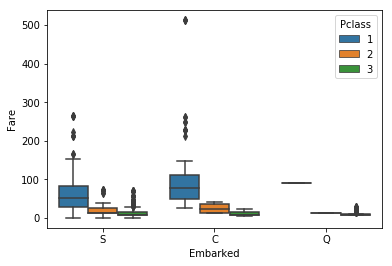

In [13]:
# We will check from where they are embarked
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data = train)

In [0]:
# We can replace the value with 'C'

train['Embarked'] = train['Embarked'].fillna('C')

In [15]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df
  
  

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

train = transform_features(train)
test = transform_features(test)
train.head()





,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


In [16]:

from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train,test)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [39]:
from sklearn.model_selection import train_test_split

X_all = train.drop(['Survived', 'PassengerId'], axis=1)
y_all = train['Survived']

num_test = 0.11
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=0)

print(X_train)

     Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Lname  NamePrefix
681       1    1    7      0      0     3      3    320          19
683       3    1    5      5      2     3      7    292          19
249       2    1    0      1      0     2      7    131          26
715       3    1    4      0      0     0      5    751          19
175       3    1    5      1      1     0      7    413          19
251       3    0    7      1      1     1      6    774          20
279       3    0    7      1      1     2      7      1          20
399       2    0    7      0      0     1      7    803          20
638       3    0    0      0      5     3      7    609          20
728       2    1    4      1      0     2      7    105          19
612       3    0    6      1      0     2      7    550          16
771       3    1    0      0      0     0      7    375          19
356       1    0    4      0      1     3      4     94          16
838       3    1    7      0      0     3      7

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

vector = SVC(random_state = 0)


parameters = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}

scorer = make_scorer(fbeta_score, beta = 0.5)

grid_obj = GridSearchCV(vector, parameters, scoring = scorer)

grid_fit = grid_obj.fit(X_train, y_train)

# vector = vector.fit(X_train,y_train)

#Get the estimator

best_classifier = grid_fit.best_estimator_

#Making predictions using this model

best_predictions = best_classifier.predict(X_test)

# Scores Report for SVM model for titanic dataset
print('Final accuracy score on the testing data:{:.4f}'.format(accuracy_score(y_test,best_predictions)))
print('Final F-score on the testing data: {:.4f}'.format(fbeta_score(y_test, best_predictions, beta = 0.5)))




/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: Und

Final accuracy score on the testing data:0.7980
Final F-score on the testing data: 0.7796


**Three- Neural Network in Pytorch**


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


In [42]:
model = Sequential()

# layers
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))

model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))

model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (test,y_test))
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.3f%%" % (model.metrics_names[1], scores[1]*100))


Train on 792 samples, validate on 99 samples
Epoch 1/100
792/792 [==============================] - 3s 3ms/step - loss: 0.6736 - acc: 0.6035 - val_loss: 0.7051 - val_acc: 0.5758
Epoch 2/100
792/792 [==============================] - 0s 61us/step - loss: 0.6638 - acc: 0.6212 - val_loss: 0.6957 - val_acc: 0.5758
Epoch 3/100
792/792 [==============================] - 0s 59us/step - loss: 0.6620 - acc: 0.6212 - val_loss: 0.6910 - val_acc: 0.5758
Epoch 4/100
792/792 [==============================] - 0s 60us/step - loss: 0.6617 - acc: 0.6212 - val_loss: 0.7142 - val_acc: 0.5758
Epoch 5/100
792/792 [==============================] - 0s 59us/step - loss: 0.6611 - acc: 0.6212 - val_loss: 0.6882 - val_acc: 0.5758
Epoch 6/100
792/792 [==============================] - 0s 65us/step - loss: 0.6609 - acc: 0.6212 - val_loss: 0.6786 - val_acc: 0.5758
Epoch 7/100
792/792 [==============================] - 0s 60us/step - loss: 0.6547 - acc: 0.6212 - val_loss: 0.6893 - val_acc: 0.5758
Epoch 8/100
792/79

In [34]:
model = Sequential()

# layers
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, validation_data = (X_test,y_test))

scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.3f%%" % (model.metrics_names[1], scores[1]*100))


Train on 596 samples, validate on 295 samples
Epoch 1/300
596/596 [==============================] - 3s 5ms/step - loss: 0.6927 - acc: 0.5268 - val_loss: 0.6906 - val_acc: 0.6237
Epoch 2/300
596/596 [==============================] - 0s 115us/step - loss: 0.6893 - acc: 0.5956 - val_loss: 0.6874 - val_acc: 0.6237
Epoch 3/300
596/596 [==============================] - 0s 113us/step - loss: 0.6859 - acc: 0.6107 - val_loss: 0.6830 - val_acc: 0.6237
Epoch 4/300
596/596 [==============================] - 0s 110us/step - loss: 0.6816 - acc: 0.6124 - val_loss: 0.6773 - val_acc: 0.6237
Epoch 5/300
596/596 [==============================] - 0s 108us/step - loss: 0.6744 - acc: 0.6124 - val_loss: 0.6742 - val_acc: 0.6237
Epoch 6/300
596/596 [==============================] - 0s 131us/step - loss: 0.6618 - acc: 0.6124 - val_loss: 0.6801 - val_acc: 0.6237
Epoch 7/300
596/596 [==============================] - 0s 112us/step - loss: 0.6627 - acc: 0.6208 - val_loss: 0.6810 - val_acc: 0.6237
Epoch 8/300

#### Results:

|     Metric     |Support Vector M/c | Neural-Network  |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |           0.7980  |        0.7621   |



**Increased the number of epochs training and added extra dropout and Batch norm layers to compete with SVMs,i.e, in order to increase the performance**

|     Metric     |Support Vector M/c | Neural-Network  |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |           0.7980  |        0.8204   |